### Gather Tutorial

The Tutorial contains general information about the Gather class, helpful attributes and some useful methods. <br>

### Content

[Intro](#Intro) <br>
[Starting](#Starting) <br>
[Attributes](#Attributes) <br>
[General Methods](#General-Methods)<br>
[Normalization Methods](#Normalization-Methods) <br>
[Conclusion](#Conclusion) <br>

In [1]:
import sys # delete after finish
sys.path.append('..') # delete after finish

from seismicpro import Survey
import matplotlib.pyplot as plt

### Intro

Пару слов о Survey <br>
Что такое Gather? <br>
В чем отличие от Survey? <br>
Зачем понадобился отдельный объект? <br>
Как помогает Gather? <br>

### Starting
We will consider the creation of a Gather class and tell about it structure.

Gather class based on Survey class [tutorial here]. поднять в Intro <br> 
We need to create Survey first.

In [2]:
sgy_path = './data/small_survey.sgy'
header_cols = ["TraceNumber", "offset", "INLINE_3D", "CROSSLINE_3D", 'CDP'] # порезать до необходимого минимума
survey = Survey(sgy_path, header_index='FieldRecord', header_cols=header_cols)

#### samle_gather

Now we could create Gather class by using 

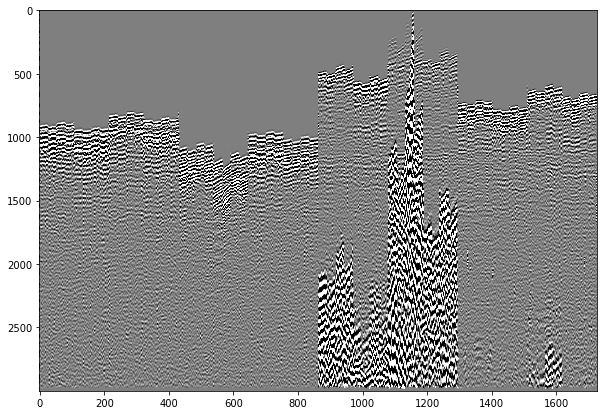

In [3]:
gather = survey.sample_gather()
gather.plot() #show here

Let's see information about the created class object

In [4]:
gather.info()


Parent survey path:          ./data/small_survey.sgy
Parent survey name:          small_survey

Number of traces:            1728
Trace length:                3000 samples
Sample rate:                 2.0 ms
Times range:                 [0.0 ms, 5998.0 ms]
Offsets range:               [79 m, 4914 m]

Index name(s):               FieldRecord
Index value:                 111919
Gather sorting:              None

Gather statistics:
Number of dead traces:       3
mean | std:                       -0.00 | 0.60      
 min | max:                     -197.41 | 196.99    
 q01 | q99:                       -1.76 | 1.75      



Tell about viewed information. Point on `Index name` and `Index value`

(!) tips <br>
Gather statistics auto calcs when `info()` called 

#### get_gather

получаем список уникальных индексов

In [5]:
survey.headers.index.drop_duplicates()

Int64Index([111916, 111917, 111918, 111919, 111920], dtype='int64', name='FieldRecord')

Объясняем метод `get_gather`

In [6]:
gather = survey.get_gather(index=111918, limits=(0,3000)) # limits remove maybe...
gather.info()


Parent survey path:          ./data/small_survey.sgy
Parent survey name:          small_survey

Number of traces:            1728
Trace length:                3000 samples
Sample rate:                 2.0 ms
Times range:                 [0.0 ms, 5998.0 ms]
Offsets range:               [79 m, 4914 m]

Index name(s):               FieldRecord
Index value:                 111918
Gather sorting:              None

Gather statistics:
Number of dead traces:       3
mean | std:                        0.00 | 0.51      
 min | max:                      -30.30 | 21.94     
 q01 | q99:                       -1.59 | 1.60      



<b> Notes </b>
если в Сюрвее есть лимиты, то они же будут в Gather

Now we learn how to create `Gather`

### Attributes

Let discuss about most useful attributes of Survey class

<b>`headers`</b> - хэддеры берем из Survey для каждой каждой трасы, попавшей в Gather. <br>

In [7]:
gather.headers

,CROSSLINE_3D,INLINE_3D,TraceNumber,CDP,offset,TRACE_SEQUENCE_FILE
FieldRecord,,,,,,
111918,492,1552,326,2057118,3266,8062
111918,592,1606,1722,2128822,3274,8070
111918,461,1606,1591,2128691,3274,8069
111918,549,1546,239,2049219,3273,8068
111918,504,1546,194,2049174,3273,8067
...,...,...,...,...,...,...
111918,540,1564,662,2073078,2276,7483
111918,513,1564,635,2073051,2276,7482
111918,572,1606,1702,2128802,2275,7481


<b>`data`</b> - trace data, numpy array with shape [Number of traces, Trace length]

In [8]:
gather.data

array([[ 1.4331881e-06,  1.0170324e-06, -5.3215190e-06, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 5.5239143e-06,  2.2677312e-05,  2.0792519e-05, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-3.2445841e-06, -1.4343628e-05, -1.9693107e-05, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       ...,
       [ 0.0000000e+00,  4.4375739e-09, -1.4841646e-07, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-1.5269310e-05, -3.3778138e-04, -7.4959965e-04, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 1.3256914e-05,  1.9857907e-05,  1.4473521e-05, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

In [9]:
gather.data.shape

(1728, 3000)

<b>`samples`</b> - array of samples with appropriate intervals, ms

In [10]:
gather.samples

array([0.000e+00, 2.000e+00, 4.000e+00, ..., 5.994e+03, 5.996e+03,
       5.998e+03], dtype=float32)

<b>`sample_rate` </b> - time resolution of traces, ms

In [11]:
gather.sample_rate

2.0

We learned about the main attributes of Gather class

`sort_by` и `mask` 
прописывать в методах 

mask using in picking tasks only

### General Methods

General methods

#### <i>plot </i>

show gather information

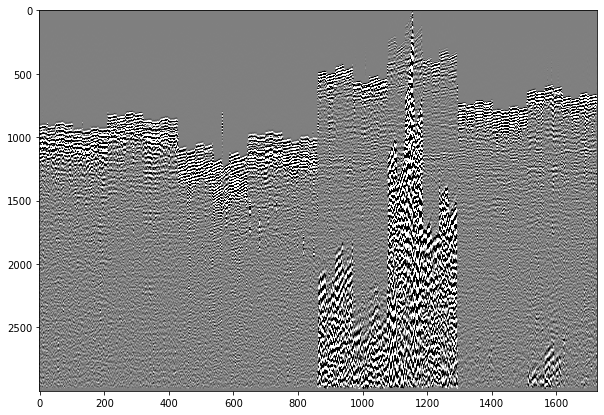

In [12]:
#gather = survey.sample_gather().sort(by='offset') # descent?
gather.plot()

#### <i>sort </i>

sort the traces in gather by headers

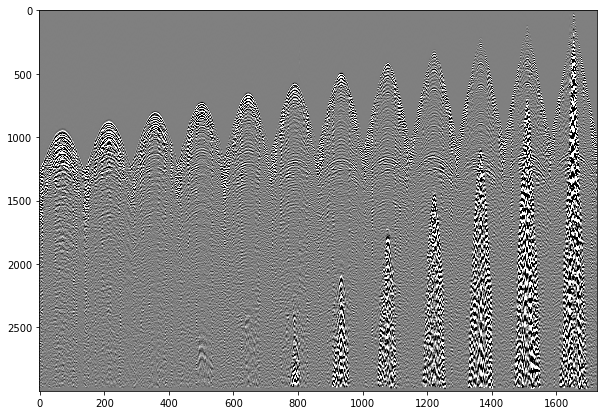

In [13]:
gather = survey.sample_gather().sort(by='CDP')
gather.plot()

добавляет атрибут `sort_by`

In [14]:
gather.sort_by

'CDP'

#### <i>copy </i>

make copy of the gather

Нужно ли сравнение копии и оригинала?
Полезный метод, т.к. все методы работают inplace

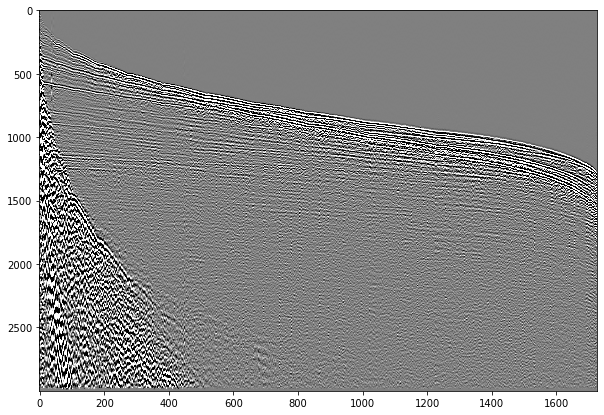

In [15]:
gather_copy = gather.copy()
gather.sort(by='offset')
gather.plot()

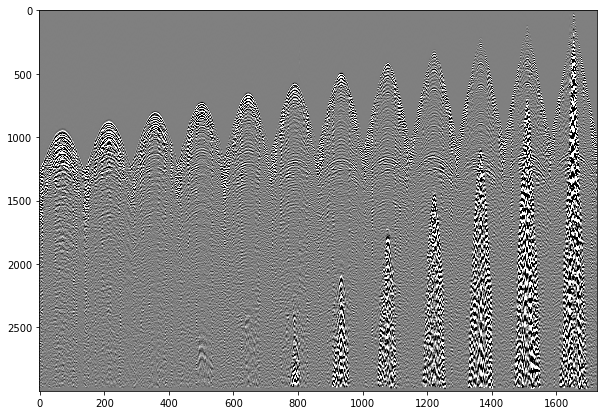

In [16]:
gather_copy.plot()

#### <i>dump </i>

save gather as file in SEG-Y format

In [17]:
gather.dump(path='./data/', name='test_gather') 

Tell about `name` and `copy_header` params

### Normalization Methods

возможно переименовать. Например Data Processing

#### <i>scale_standard </i>

Приведение значений трасс к среднему 0 и дисперсии 1

All methods works inplace. I use copy to show you how methods work on the base `Gather`.

In [18]:
gather_scaled = gather.copy()

gather_scaled.scale_standard()
print(f'Mean of all trace is {gather_scaled.data.mean():.2f}')
print(f'Standart deviation of all trace is {gather_scaled.data.std():.2f}')

Mean of all trace is -0.00
Standart deviation of all trace is 1.00


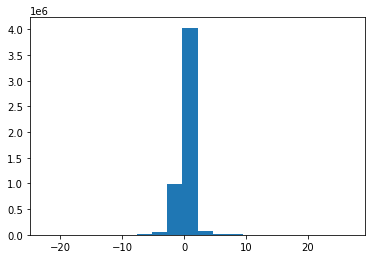

In [19]:
_ = plt.hist(gather_scaled.data.ravel(), bins=20)

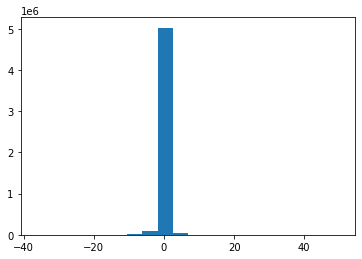

In [22]:
gather_scaled = gather.copy()
gather_scaled.scale_standard(use_global=True)
_ = plt.hist(gather_scaled.data.ravel(), bins=20)

In [21]:
survey.collect_stats()

Calculating statistics for survey small_survey:   0%|          | 0/8640 [00:00<?, ?it/s]

#### <i>scale_maxabs </i>gather.scale_standard()
gather.info()

In [24]:
gather_scaled = gather.copy()

gather_scaled.scale_maxabs()
print(f'Min of all trace is {gather_scaled.data.min():.2f}')
print(f'Max of all trace is {gather_scaled.data.max():.2f}')

Min of all trace is -1.00
Max of all trace is 1.00


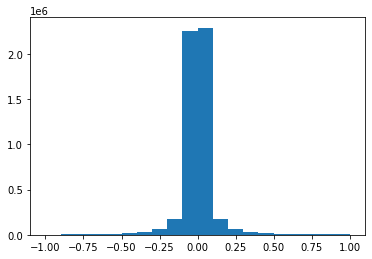

In [25]:
_ = plt.hist(gather_scaled.data.ravel(), bins=20)

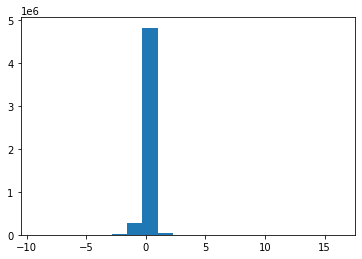

In [26]:
gather_scaled = gather.copy()
gather_scaled.scale_maxabs(q_min=0.01, q_max=0.99)
_ = plt.hist(gather_scaled.data.ravel(), bins=20)

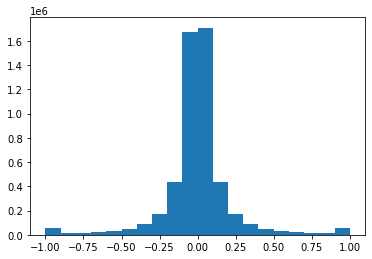

In [27]:
gather_scaled = gather.copy()
gather_scaled.scale_maxabs(q_min=0.01, q_max=0.99, clip=True)
_ = plt.hist(gather_scaled.data.ravel(), bins=20)

#### <i>scale_minmax </i>

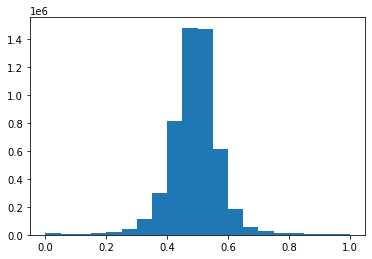

In [28]:
gather_scaled = gather.copy()

gather_scaled.scale_minmax()
_ = plt.hist(gather_scaled.data.ravel(), bins=20)

### Muter

subblock with `mute` and `create_muter` methods

First create `Muter` object with `create_muter` method

only `from_point` mode explain

In [ ]:
gather_muted = gather.copy()
offsets = [50, 1500, 2000, 4000]
times = [500, 2000, 1000, 6000]
points = {'offsets': offsets, 'times': times}
muter = gather_muted.create_muter('points', **points)

Second mute еру traces in `Gather` with `Muter` object

In [ ]:
gather_muted.mute(muter, fill_value=0)

In [ ]:
gather_muted.plot()

#### <i>qet_quantile </i>

return quantile
убрать в низ блока нормализации
упомянуть не более

In [ ]:
gather.get_quantile(0.01)

could return requested quantile of each trace in Gather if `tracewise=True`

In [ ]:
gather.get_quantile(0.01, tracewise=True)

could use Survey statistic if its already calculated with `Survey.collect_stats()` <br>
`gather.get_quantile(0.01, use_global=True)`

In [ ]:
survey.collect_stats()
gather.get_quantile(0.01, use_global=True)

### Conclusion

In this tutorial we looked at `Gather` class <br>

Now we could create `Gather` from `Survey` <br>
Learned about the main attributes of this class <br>
Showed how the main methods works <br>

More information and full documentation you could find [here] <br>

Hope it was been useful for you <br>